In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from psutil import virtual_memory
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#!ln -s "/content/drive/My Drive/Colab Notebooks/data/" "/content/data"

Mounted at /content/drive
ln: failed to create symbolic link '/content/facemask_data/facemask_data': File exists


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from random import choice
import shutil
from glob import glob                                                           
import cv2 
import numpy as np
from imutils import paths

imagePaths = list(paths.list_images('/content/data'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
print(data.shape)
print(labels.shape)

print(data[0:5])
print(labels)

(337, 224, 224, 3)
(337,)
[[[[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  [[-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   ...
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]
   [-1.         -1.         -1.        ]]

  ...

  [[-0.42745095 -0.42745095 -0.42745095]
   [-0.41960782 -0.41960782 -0.41960782]
   [-0.41176468 -0.41176468 -0.41176468]
   ...
   [-0.04313725 -0.04313725 -0.04313725]
   [-0.1372549  -0.15294117 -0.

In [ ]:
# Apply transfer learning and fine tunning

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze it.
# Frozen model will update from the second iteration.
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# Binarize and transform the labels to categorial: 1 mask, 0 no mask
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#Compile and fit the model

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")

opt = Adam(learning_rate=INIT_LR, decay = INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
8/8 [==============================] - 12s 1s/step - loss: 0.6616 - accuracy: 0.6371 - val_loss: 0.5455 - val_accuracy: 0.7941
Epoch 2/20
8/8 [==============================] - 8s 940ms/step - loss: 0.5800 - accuracy: 0.7300 - val_loss: 0.4550 - val_accuracy: 0.8235
Epoch 3/20
8/8 [==============================] - 8s 931ms/step - loss: 0.4556 - accuracy: 0.8397 - val_loss: 0.3706 - val_accuracy: 0.9118
Epoch 4/20
8/8 [==============================] - 8s 954ms/step - loss: 0.3791 - accuracy: 0.8903 - val_loss: 0.3040 - val_accuracy: 0.9559
Epoch 5/20
8/8 [==============================] - 8s 992ms/step - loss: 0.3380 - accuracy: 0.9023 - val_loss: 0.2574 - val_accuracy: 0.9706
Epoch 6/20
8/8 [==============================] - 8s 1s/step - loss: 0.3099 - accuracy: 0.9156 - val_loss: 0.2209 - val_accuracy: 0.9706
Epoch 7/20
8/8 [==============================] - 8s 929ms/step - loss: 0.2502 - accuracy: 0.9241 - val_loss: 0.1937 - val_accuracy: 0.9706
Epoch 8/20
8/8 [=========

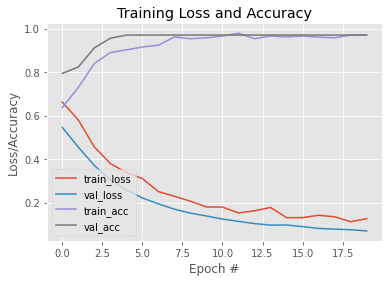

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.save('/content/models/facemask_keras_opencv.h5')